# Estimating $a$ from spiral tip trajectories
Tim Tyree<br>
9.5.2023

In [1]:
import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

In [2]:
os.chdir(nb_dir)
from lib import *

In [3]:
import cupy, cudf
from lib.rapids_func import *

In [417]:
import seaborn as sns
import matplotlib.ticker as mtick
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [6]:
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

# define module

# dev
- step 1: reproduce known value for $a$
- step 2: compute $a$ for new folder of tip trajectories. did $a$ change?

In [501]:
min_duration=40
DS=5./200.
width=200
height=200
tmin=100
# DT=1. #ms/frame
# width=200.  #pixels
# height=200. #pixels
# tavg1=0.  #moving average window, in ms
# tavg2=14., #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
min_termination_time=100.
min_duration_thresh=1. #ms #minimum lifetime for a spiral tip position to be considered
max_Rfinal_thresh=0.5  #cm
max_dtmax_thresh= 0.   #cm # max disagreement between tmax for _self relative to _other
round_t_to_n_digits=7
t_col='t'
pid_col='particle'
trial_col='trial_num'
use_tavg2=True #unsmoothed R is preserved through R_nosavgol
testing=True
printing=True#,**kwargs):
use_flip_tdeath=False  #True could need implementing
minlifetime=40.#ms
Rcol='R_nosavgol'
taucol='tdeath'
# pid_mate='pid_birthmate'
# r_mate='r0'
pid_mate='pid_deathmate'
r_mate='rT'
minr=1.5 #cm
minr=0.25 #cm
# minr=0.2 #cm
# minr=0.3
minr=0.35
# minr=0.5 #cm
# minr=1 #cm

In [550]:
# jump_thresh=.3
jump_thresh=.5
# jump_thresh=3 #<<<expect this to increase apparent $a$
# np.diff(R_values).max<jump_thresh
# x_values=
# jump_index_array, spd_lst = find_jumps(x_values,y_values,width=width,height=height, DS=DS,DT=DT, jump_thresh=None)

In [565]:
# input_folder= f"{nb_dir}/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories"  #2 min run time
input_folder= f"{nb_dir}/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/trajectories"

input_fn_lst = os.listdir(input_folder)
#TODO(later): remove .DS_Store on mac explicitely
df_R_lst=[]
for trial_num,input_fn in enumerate(input_fn_lst):
    input_dir=os.path.join(input_folder,input_fn)
    df_traj=pd.read_csv(input_dir)
    df_interactions=compute_df_interactions(input_dir,DS=DS,width=width,height=height,tmin=tmin,pid_col='particle',t_col='t',
                                            min_duration=min_duration)#,**kwargs)
    l=list (df_traj.groupby(t_col).groups.keys())
    DT=np.around(l[1]-l[0],round_t_to_n_digits)
    # df_R_lst=[]
    # boo = (df_interactions[['rT']].values*DS<minr).flatten()
    boo = (df_interactions[[r_mate]].values*DS<minr).flatten()
    # boo = (df_interactions[['r0']].values*DS<minr).flatten()
    for i,row in df_interactions.loc[boo].iterrows():
        pid1=int(row['pid'])
        pid2=int(row['pid_deathmate'])
        d=df_traj[df_traj['particle']==pid1]\
            .set_index('frame')[['x','y']]\
            .rename(columns={'x':'x_self','y':'y_self'})
        d2=df_traj[df_traj['particle']==pid2]\
            .set_index('frame')[['x','y']]
        d['x_other']=d2['x']
        d['y_other']=d2['y']
        #compute the three options for the square distance with pbc
        d['sdx']=(d['x_self']-d['x_other'])**2
        d['sdxp']=(d['x_self']-d['x_other']+width)**2
        d['sdxm']=(d['x_self']-d['x_other']-width)**2
        d['sdy']=(d['y_self']-d['y_other'])**2
        d['sdyp']=(d['y_self']-d['y_other']+height)**2
        d['sdym']=(d['y_self']-d['y_other']-height)**2
        #choose the minimum of each class of option
        d['minsdx']=d[['sdx','sdxp','sdxm']].min(axis=1)
        d['minsdy']=d[['sdy','sdyp','sdym']].min(axis=1)
        d['dist']=np.sqrt(d['minsdx'] + d['minsdy'])
        # d['dist']=(d['minsdx'] + d['minsdy'])**0.5
        d['R']=d['dist']*DS

        use_reverse_time=True
        R_values=d['R'].values
        if use_reverse_time:
            R_values = np.array(list(reversed(R_values)))
        N=R_values.shape[0]
        tdeath_values=np.arange(0,DT*N,DT)
    #     tdeath_values.shape,R_values.shape
        #TODO(later): optionally, later, if needed align R timeseries
        df_R=pd.DataFrame({'R':R_values,
                           'tdeath':tdeath_values,
                           'pid1':pid1,
                           'pid2':pid2,
                          })
        df_R['trial_num']=trial_num
        #record if no jumps
        if np.abs(np.diff(R_values)).max()<jump_thresh:
            #record
            df_R_lst.append(df_R)
df_R = pd.concat(df_R_lst)

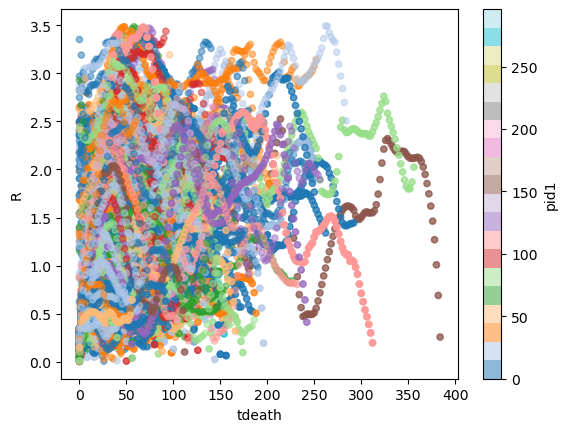

In [566]:
df_R.plot(kind='scatter',x='tdeath',y='R',c='pid1',cmap='tab20',alpha=0.5)
plt.show()

In [567]:
#DONE: aggregate over many trials
df_R

,R,tdeath,pid1,pid2,trial_num
0,0.244889,0.0,0,1,0
1,0.408819,2.0,0,1,0
2,0.503906,4.0,0,1,0
3,0.559827,6.0,0,1,0
4,0.617426,8.0,0,1,0
...,...,...,...,...,...
24,0.453202,48.0,46,45,167
25,0.434683,50.0,46,45,167
26,0.432203,52.0,46,45,167
27,0.484504,54.0,46,45,167


In [568]:
R_dir=input_folder.replace('/trajectories','/annihilation_ranges.csv')
df_R.to_csv(R_dir,index=False)
print(f"{R_dir=}")

R_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_ranges.csv'


In [569]:
beep(3)



0

In [570]:
R_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/annihilation_ranges.csv'
R_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_ranges.csv'

In [541]:
# input_fn = f"{nb_dir}/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/"
# input_fn = f"{nb_dir}/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories/ic001.11_traj_sr_600_mem_0.csv"
# input_fn = f"{nb_dir}/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.001/trajectories/ic001.11_traj_sr_600_mem_0.csv"
# param_qu_tmax_30_Ko_3.8_diffCoef_0.0005/
#DONE: load ^that
#DONE: compute df_R
#TODO: compute df_msr, as before
#TODO: plot msr versus t'
#TODO: compute $a$, as before

,t,n,x,y,grad_ux,grad_uy,grad_vx,grad_vy,frame,particle
0,100.1,6,55.285006,100.978964,3.696059,-0.475831,-0.959494,2.068673,0,0
1,100.1,6,70.680559,152.937427,-0.010189,1.468965,-1.052768,1.941831,0,1
2,100.1,6,111.309524,178.845106,0.626382,1.234434,1.626507,0.610616,0,2
3,100.1,6,146.637794,98.511666,1.022848,0.966264,-2.180008,5.738618,0,3
4,100.1,6,185.928201,72.243527,6.608389,-13.432443,0.990710,1.023562,0,4


In [544]:
# for i,row in df_interactions.iterrows():
#     if minr>=DS*row[r_mate]:
#         pid1 = int(row['pid'])
#         pid2 = int(row[pid_mate])
# #         pid_mate = row[pid_mate]
#         #DONE: measure the range vs. time of pid1,2 for annihilation event
#         #TODO: measure the range vs. time of pid1,2 for creation event

# scratchwerk

In [224]:
df=cudf.DataFrame(df_traj)
df['trial_num']=-1
# df['index']=df.index.values
df['index']=df.reset_index().index.values
# df.set_index(['trial_num','particle','frame'],inplace=True)
# df.set_index(['frame'],inplace=True)
# df

In [248]:

dfr, df_pairs = compute_radial_velocities_of_annihilations_cu(df,#.set_index(['trial_num','pid_self']),#.reset_index(),
        navg2=0, #num. frames to average over.  navg2 must be an odd, positive integer.
        DS=DS,    #cm/pixel
        DT=DT,   #ms/frame
        width=width,
        height=height,
        max_dtmax_thresh=max_dtmax_thresh,  #ms
        max_Rfinal_thresh=max_Rfinal_thresh,  #cm
        min_duration_thresh=min_duration_thresh,  #ms
        use_tavg2=use_tavg2,
        pid_col=pid_col,
        trial_col=trial_col,
        use_dask=False,
        printing=printing,
        testing=False)#testing)
dfr.reset_index(inplace=True)
# dfr.head()

if use_flip_tdeath:
    pass
    #dfr['tdeath']=??
#TODO(later): implememnt ^that

df_R_lst=[]
for (trial_num,pid_self,pid_other),g in dfr.groupby(by=['trial_num','pid_self','pid_other']):
    lifetime=g.shape[0]*DT
    if lifetime>=minlifetime:
        df_R_lst.append(g.sort_values(by=taucol)[['trial_num','pid_self','pid_other',taucol,Rcol]].to_pandas())
#         print(f"{trial_num,pid_self,pid_other}")
df_R = pd.concat(df_R_lst)
# df_R_lst
df_R.head()

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [207]:
#TODO: collect over all trials
#TODO: average the first 40 ms
#TODO: fit and measure $a$, as before

In [209]:
# dfr
# g.sort_values(by=taucol)[['trial_num','pid_self','pid_other',taucol,Rcol]].to_pandas()